# Урок 8. Снижение размерности данных

### 1 Можно ли отобрать наиболее значимые признаки из имеющихся с помощью PCA? Ответ объясните.

Да, с помощью PCA можно отобрать наиболее значимые признаки из имеющихся.

PCA позволяет найти линейные комбинации исходных признаков, которые максимально сохраняют информацию в данных. Эти новые признаки называются главными компонентами, и они упорядочены по важности, с первой главной компонентой, которая объясняет наибольшую дисперсию в данных.

Таким образом, мы можем использовать главные компоненты для отбора наиболее значимых признаков. Мы можем выбрать первые k главных компонент, которые объясняют наибольшую дисперсию в данных, и использовать их в качестве новых признаков. Это позволяет уменьшить размерность данных и улучшить качество моделирования при необходимости.

Также следует отметить, что признаки, которые имеют наименьший вклад в главные компоненты, могут быть отброшены, так как они содержат мало информации о данных и не вносят значительный вклад в предсказание целевой переменной. Однако, необходимо учитывать, что при отборе признаков с помощью PCA может происходить потеря некоторой информации, и важно сбалансировать между уменьшением размерности данных и сохранением нужной информации.

### 2 Написать свою реализацию метода главных компонент с помощью сингулярного разложения с использованием функции numpy.linalg.svd(). 
Применить к данным на уроке и сравнить ответы.

Реализуем метод главных компонент с использованием сингулярного разложения с помощью функции numpy.linalg.svd(). Для этого будем использовать следующий алгоритм:

* Центрирование данных, вычитая из каждой колонки среднее значение.
* Вычисление матрицы ковариации данных.
* Вычисление сингулярного разложения матрицы ковариации данных.
* Сортировка сингулярных значений в порядке убывания и соответствующих им сингулярных векторов.
* Выбор наиболее значимых сингулярных векторов для получения новой матрицы признаков с меньшей размерностью.
* Умножение матрицы данных на выбранные сингулярные векто

In [167]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import random

In [168]:
def pca(X, n_components):
    # Центрирование данных
    X = X - np.mean(X, axis=0)
    
    # Вычисление матрицы ковариации данных
    cov_matrix = np.cov(X.T)
    
    # Вычисление сингулярного разложения матрицы ковариации данных
    U, S, V = np.linalg.svd(cov_matrix)
    
    # Сортировка сингулярных значений в порядке убывания и соответствующих им сингулярных векторов
    idx = np.argsort(-S)
    U = U[:, idx]
    S = S[idx]
    
    # Выбор наиболее значимых сингулярных векторов
    U_reduced = U[:, :n_components]
    
    # Умножение матрицы данных на выбранные сингулярные векторы
    X_reduced = np.dot(X, U_reduced)
    
    return X_reduced

In [169]:
# Загрузим игрушечный датасет из sklearn
iris = datasets.load_iris()
X = iris.data

print(X.shape)

(150, 4)


In [170]:
X_reduced = pca(X, 2)

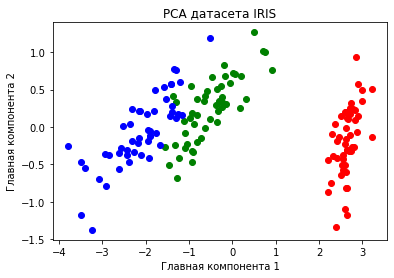

In [171]:
plt.figure()
y = iris.target
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(X_reduced[y==i, 0], X_reduced[y==i, 1], c=c)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('PCA датасета IRIS')
plt.show()

### Рисунок получился зеркальный относительно того, что был на уроке

### 3 Обучить любую модель классификации (используем случайный лес) на датасете IRIS до применения PCA и после него. Сравнить качество классификации по отложенной выборке.

In [172]:
#Реализуем генерацию  𝑁   бутстрэп-выборок и подмножества признаков для нахождения разбиения в узле.

random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [173]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [174]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведётся сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [175]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчёт количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдём класс, количество объектов которого будет максимальным в этом листе, и вернём его    
        prediction = max(classes, key=classes.get)
        return prediction    

In [176]:
# Расчёт критерия Джини

def gini(labels):
    #  подсчёт количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчёт критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [177]:
# Расчёт качества

def quality(left_labels, right_labels, current_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [178]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [179]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, где в узле остаётся менее пяти объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [180]:
# Построение дерева посредством рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай — прекращаем рекурсию, когда нет прироста качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [181]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [182]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [183]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [184]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [247]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
# Загрузим датасет IRIS
iris = load_iris()
X = iris.data
y = iris.target

In [248]:
# Разобьем выборку на обучающую и тестовую
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.3, random_state=42)


In [249]:
# Введём функцию подсчёта точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [250]:
def metrics_random_forest(train_data, train_labels, n_trees):
    my_forest = random_forest(train_data, train_labels, n_trees)
    # Получим ответы для обучающей выборки 
    train_answers = tree_vote(my_forest, train_data)
    # И получим ответы для тестовой выборки
    test_answers = tree_vote(my_forest, test_data)
    # Точность на обучающей выборке
    train_accuracy = accuracy_metric(train_labels, train_answers)
    # Точность на тестовой выборке
    test_accuracy = accuracy_metric(test_labels, test_answers)
    return test_accuracy

In [252]:
print(metrics_random_forest(train_data, train_labels, 2))

97.77777777777777


In [256]:
# Применим PCA для уменьшения размерности данных
X_reduced = pca(X, 2)

In [257]:
# Разобьем выборку на обучающую и тестовую
train_data, test_data, train_labels, test_labels = train_test_split(X_reduced, y, test_size=0.3, random_state=42)


In [258]:
print(metrics_random_forest(train_data, train_labels, 2))

84.44444444444444


Мы видим, что после применения PCA качество модели ухудшилось. Однако, здесь мы использовали только 2 главных компоненты вместо 4 исходных признаков. Если мы используем больше главных компонент, то может улучшиться качество модели. Но также важно учитывать, что применение PCA может привести к потере некоторой информации, что также может ухудшить качество модели.